In [1]:
"""dysfunctional programming in python"""
__version__ = "0.2.3"
__all__ =  "λ", "Λ", "poser", "this", "star"

`λ` is an `object` for fluent function composition in `"python"` based on the `toolz` library.

1.  [__Motivation__](#Motivation)
2. [__Source__](#Source)
3. [__Tests__](#Tests)

#### Motivation

[Function composition](https://en.wikipedia.org/wiki/Function_composition) is a common task in mathematics and modern programming.
Object oriented function composition often breaks with conventional representations.
The `toolz` library provides a set of functional programming objects to `compose` and `pipe` functions together.
`compose` and `pipe` are top level composition functions that how two different typographic conventions.

In the `toolz` example, both `f and g` are the same

1. `compose` mimics a symbollic function composition.

        f = compose(type, len, range)
    
1. `pipe` allows a fluent composition.

        g = lambda x: pipe(x, range, len, type)
        def h(x: int) -> type: return pipe(x, range, len, type)
        
The typology of the `compose` composition is destructive to the flow of literature because it must be read `reversed`. 
`pipe` on the other hand supplements the narrative providing literate compositions aligned with the direction of the literature.

From a learning perspective, my experience with `poser` & its predecessors have taught me a lot about the pythonic data model.
`Compose` expresses a near complete symbollic API for function composition.

In [2]:
    import toolz, abc, inspect, functools, operator, typing, importlib, builtins, pathlib, operator, ast, itertools, sys
    from toolz.curried import *

#### Source

`Compose` augments `toolz.Compose` to provide a fluent & symbollic object for function composition in python.

In [3]:
    class Composition(toolz.functoolz.Compose):        
        __slots__ = toolz.functoolz.Compose.__slots__ + tuple("args kwargs exceptions".split())
        
        def __init__(self, funcs=None, *args, **kwargs): 
            """Compose stores args and kwargs like a partial."""
            super().__init__(funcs or (I,)); self.args, self.exceptions, self.kwargs = args, kwargs.pop('exceptions', tuple()), kwargs
        
        def __iter__(x): yield x.first; yield from x.funcs
        def __bool__(x): return not isinstance(x, type)
        
        def __call__(x, *tuple, **dict):
            if not isinstance(x, star):
                tuple, dict = x.args + tuple, {**x.kwargs, **dict}
            for callable in x: 
                try:
                    tuple, dict = (callable(*tuple, **dict),), {}
                    object = tuple[0]
                except x.exceptions as Exception: return Ø(Exception)
            return object
        
        def __len__(self):
            if isinstance(self, type): return 0
            
            return (self.funcs and len(self.funcs) or 0)+1
        
        def partial(this, object=None, *args, **kwargs):
            """append a `partial` an `object` to this composition."""
            if isinstance(this, type) and issubclass(this, Composition): this = this()
            if not isinstance(object, Λ):
                if object is None: return this
                if isinstance(object, slice): 
                    if normal_slice(object):
                        return type(this)(funcs=list(this)[object])
                    else:
                        callable(object.start) and this.filter(object.start)
                        callable(object.stop) and this.map(object.stop)
                        callable(object.step) and this.partial(object.step)
                        return this
            
            if args or kwargs: object = toolz.partial(object, *args, **kwargs)                
            if this.first is I: this.first = object
            else: this.funcs += object,
            return this

### Utility functions

In [4]:
    def istype(object, cls):
        return isinstance(object, type) and issubclass(object, cls)

In [5]:
    def _evaluate(object, property=None):
        try:
            object = importlib.import_module(object)
            if property is None: return object
        except ModuleNotFoundError: 
            module, sep, next = object.rpartition('.')
            property = next if property is None else F"{next}.{property}"
        else: return operator.attrgetter(property)(object)
        return _evaluate(module, property)

In [6]:
    class Explicit(typing.ForwardRef, _root=False):
        def __new__(cls, object, *args, **kwargs):
            if not isinstance(object, str): return object
            try: ast.parse(object)
            except SyntaxError: return object # if the forward reference isn't valid code...
            self = super().__new__(cls); self.__init__(object, *args, **kwargs)
            return self
        def __call__(self, *args, **kwargs):
            object = self._evaluate()
            return object(*args, **kwargs) if callable(object) else object
        
        def _evaluate(self, globalns=None, localns=None):
            self.__forward_value__ = _evaluate(self.__forward_arg__)
            self.__forward_evaluated__ = True
            return self.__forward_value__
        
        def __repr__(x): return repr(x._evaluate()) if x.__forward_evaluated__ else super().__repr__()        
        @property
        def __signature__(x): return inspect.signature(x._evaluate())
        @property
        def __doc__(x): return inspect.getdoc(x._evaluate())
        def __str__(x): return x.__forward_arg__


    def I(*tuple, **_): "A nothing special identity function, does pep8 peph8 me?"; return tuple[0] if tuple else None
    
    @functools.wraps(toolz.map)
    def map(callable, object, key=None, *, property=map):
        """A general `map` function for sequences and containers."""
        if isinstance(object, typing.Mapping):
            if key is not None: object = getattr(toolz, F"key{property.__name__}")(key, object)
            return getattr(toolz, F"val{property.__name__}")(callable, object)
        return getattr(toolz, property.__name__)(callable, object)
            
    filter = functools.wraps(filter)(functools.partial(map, property=filter))

    class juxt(toolz.functoolz.juxt):
        def __new__(self, funcs):
            if isinstance(funcs, str): funcs = Explicit(funcs)
            if callable(funcs) or not toolz.isiterable(funcs): return funcs
            self = super().__new__(self)
            return self.__init__(funcs) or self
        
        def __init__(self, object): self.funcs = object
            
        def __call__(self, *args, **kwargs):
            if isinstance(self.funcs, typing.Mapping):
                object = type(self.funcs)()
                for key, value in self.funcs.items():
                    if callable(key): key = juxt(key)(*args, **kwargs)
                    if callable(value): value = juxt(value)(*args, **kwargs)
                    object[key] = value
                else: return object
            if toolz.isiterable(self.funcs): 
                return type(self.funcs)(
                    juxt(x)(*args, **kwargs) 
                    if (callable(x) or toolz.isiterable(x)) else x 
                    for x in self.funcs)                    
            if callable(self.funcs): return self.funcs(*args, **kwargs)
            return self.funcs

    class Ø(BaseException):
        def __bool__(self): return False

In [7]:
    def normal_slice(slice):
        return all(
            isinstance(x, (int, type(None)))
            for x in operator.attrgetter(*'start stop step'.split())(slice)
        )

In [8]:
    class Extensions:
        _flip = {}
        _partial = {}
        _method = {}


In [9]:
    def flip(callable, *args, **kwargs):
        @functools.wraps(callable)
        def call(*a, **k):
            return callable(*a, *args, **{**kwargs, **k})
        return call

In [10]:
    class Compose(Composition, Extensions):
        """`__add__ or partial` a function into the composition."""
        def partial(x, object=None, *args, **kwargs):
            if object is Ellipsis: return x() # call when we see ellipsis.
            return Composition.partial(x, juxt(object), *args, **kwargs)
            
        @property
        def __doc__(x): return inspect.getdoc(x.first)

        __pos__ = __rshift__ = __sub__ = __rsub__ = __isub__ = __add__ = __radd__ = __iadd__ = __getitem__ = partial
                
        @property
        def __signature__(x): return inspect.signature(x.first)
        
        """Mapping, Filtering, Groupby, and Reduction."""
        def map(λ, callable, key=None): return λ[toolz.partial(map, juxt(callable), key=juxt(key))]
        __mul__ = __rmul__ = __imul__ = map
        
        def filter(λ, callable, key=None): return λ[toolz.partial(filter, juxt(callable), key=juxt(key))]
        __truediv__ = __rtruediv__ = __itruediv__ = filter
        
        def groupby(λ, callable): return λ[toolz.curried.groupby(juxt(callable))]
        __matmul__ = __rmatmul__ = __imatmul__ = groupby
        
        def reduce(λ, callable): return λ[toolz.curried.reduce(juxt(callable))]
        __mod__ = __rmod__ = __imod__ = reduce
        
        """Conditionals."""
        def excepts(x, *Exceptions): return λ(exceptions=Exceptions)[x]
        __xor__ = excepts
        
        def ifthen(λ, callable): return IfThen(λ)[callable]
        __and__ = ifthen
        
        def ifnot(λ, callable): return IfNot(λ)[callable]
        __or__ = ifnot
        
        def issubclass(λ, object): 
            return λ[toolz.partial(toolz.flip(istype), object)]
        
        def isinstance(λ, object): 
            return λ[toolz.partial(toolz.flip(isinstance), object)]
            
        def condition(λ, object):
            return IfThen(λ.isinstance(object) if isinstance(object, (tuple, type)) else λ[object])
        __pow__ = __ipow__ = condition
        
        def skip(self, bool:bool=True): return bool and self.off() or self.on()
        def on(self): return self
        def off(self): return self[:-1]
                
        
        def do(λ, callable): return λ[toolz.curried.do(juxt(callable))]
        __lshift__ = do
                
        def complement(x, object=None): return λ[toolz.complement(x)] if object == None else x[toolz.complement(object)]
        __neg__ = complement
        def flip(x, object=None): return λ[toolz.flip(x)] if object == None else x[toolz.flip(object)]
        __invert__ = flip
        
        
        def __abs__(x): return Composition(*(object for object in reversed((x.first,) + x.funcs)))
        def __reversed__(x):
            new = +type(x)
            for object in reversed((x.first,) + x.funcs): new[object]
            else: return new
            
        """Object tools"""
        def attrgetter(this, *args, **kwargs): return this[operator.attrgetter(*args, **kwargs)]
        def itemgetter(this, *args, **kwargs): return this[operator.itemgetter(*args, **kwargs)]
        def methodcaller(this, *args, **kwargs): return this[operator.methodcaller(*args, **kwargs)]
        
        def _ipython_key_completions_(self):
            object = []
            try:
                object = __import__('IPython').core.completerlib.module_completion('import')
            except: return [] # we wont need this if ipython ain't around
            return object + list(itertools.chain(*[
                [F"{k}.{v}" for v in dir(v) if not v.startswith('_')] for k, v in sys.modules.items()
            ]))
        
        def __getattribute__(cls, str):
            try:
                return object.__getattribute__(cls, str)
            except AttributeError as e: Exception = e
            if str in cls._partial:
                @functools.wraps(cls._partial[str])
                def defer(*args, **kwargs):
                    nonlocal str, cls
                    return cls.partial(cls._partial[str], *args, **kwargs)
                return defer
            elif str in cls._flip:
                @functools.wraps(cls._flip[str])
                def defer(*args, **kwargs):
                    nonlocal str, cls
                    return cls.partial(flip(cls._flip[str], *args, **kwargs))
                return defer                

            elif str in cls._method:
                @functools.wraps(cls._method[str])
                def defer(*args, **kwargs):
                    nonlocal str, cls
                    return cls.partial(cls._method[str](*args, **kwargs))
                return defer                
            raise Exception
        
        def __dir__(cls):
            return sorted(super().__dir__(cls) + sum(map(list, (cls._method, cls._flip, cls._partial)), []))
        
        def first(cls):
            return cls[iter][next]

In [11]:
    class Conditional(Compose):
        def __init__(self, predicate, *args, **kwargs): self.predicate = super().__init__(*args, **kwargs) or predicate
            
    class IfThen(Conditional):
        def __call__(self, *args, **kwargs):
            object = self.predicate(*args, **kwargs)
            return super().__call__(*args, **kwargs) if object else object
        
    class IfNot(Conditional):
        def __call__(self, *args, **kwargs):
            object = self.predicate(*args, **kwargs)
            return object if object else super().__call__(*args, **kwargs)

In [12]:
    class Type(abc.ABCMeta, Extensions): 
        __getattribute__ = Compose.__getattribute__
        def __dir__(cls):
            return sorted(super().__dir__() + sum(map(list, (cls._method, cls._flip, cls._partial)), []))
        partial = Compose.partial

        __getitem__ = Compose.__getitem__
    _type_method_names = set(dir(Type))
    for attr in (
        set(dir(Compose))
        - (set(dir(toolz.functoolz.Compose)))
        - set("__weakref__ __dict__".split())
    ):
        setattr(Type, attr, getattr(Type, attr, getattr(Compose, attr)))
    _type_method_names = set(dir(Type))        
    
    class λ(Compose, metaclass=Type): 
        def __init__(self, *args, **kwargs): super().__init__(kwargs.pop('funcs', None), *args, **kwargs)
            
    poser = λ

In [13]:
    class star(λ, Compose, metaclass=Type):
        def __call__(x, *object, **dict):
            args, kwargs = list(), {}
            for arg in x.args + object:
                kwargs.update(arg) if isinstance(arg, typing.Mapping) else args.extend(arg) 
            return super().__call__(*args, **kwargs)

In [14]:
    def _defined(str): 
        return any([
            str in Extensions._flip, 
            str in Extensions._partial,
            str in Extensions._method, 
            str in _type_method_names 
        ])

    Compose._method.update(dict(itemgetter=operator.itemgetter, attrgetter=operator.attrgetter, methodcaller=operator.methodcaller))
    for key, value in toolz.merge(
        toolz.pipe(
            {x: getattr(object, x) for x in dir(object)}, 
            toolz.curried.valfilter(callable), 
            toolz.curried.keyfilter(toolz.compose(str.isalpha, toolz.first))
        ) for object in reversed((builtins, operator, str, dict, list, pathlib.Path, __import__('fnmatch')))
    ).items(): _defined(key) or Compose._flip.update({key:value})
    for _ in "compile glob".split(): Compose._flip.pop(_)
    del _
    for key, value in toolz.merge(
        toolz.pipe(
            {x: getattr(object, x) for x in dir(object)}, 
            toolz.curried.valfilter(callable), 
            toolz.curried.keyfilter(toolz.compose(str.isalpha, toolz.first))
        ) for object in reversed((toolz, inspect,
                                  __import__('IPython').display if 'IPython' in sys.modules else inspect,
                         *map(__import__, "copy io typing types dataclasses abc statistics itertools json math string random re glob ast dis tokenize".split()),
                        ))
    ).items(): _defined(key) or Compose._partial.update({key:value})
    Compose._partial.update(dict(Path=pathlib.Path))
    
        

In [15]:
    def attribute(property, *args, **kwargs):
        def attribute(object):
            """Return an attrgetter or methodcaller."""
            object = getattr(object, property)
            return object(*args, **kwargs) if args or kwargs or callable(object) else object
        return attribute
    
    class ThisType(abc.ABCMeta):
        def __getitem__(x, object): return x().__getitem__(object)
        def __getattr__(x, str): return x().__getattr__(str)

    class Λ(Composition, metaclass=ThisType):
        """
        >>> λ[(10 - Λ), abs(10 - Λ)](20)
        (-10, 10)
        """
        def __getitem__(x, object): return x.partial(operator.itemgetter(object))
        def __getattr__(x, object):
            def partial(*args, **kwargs): return x.partial(attribute(object, *args, **kwargs))
            return partial
    for binop in "add sub mul matmul truediv floordiv mod eq lt gt ne xor".split():
        for cls in (ThisType, Λ):
            setattr(cls, F"__{binop}__", functools.wraps(getattr(operator, binop))(functools.partialmethod(Composition.partial, toolz.flip(getattr(operator, binop)))))
            setattr(cls, F"__i{binop}__", functools.wraps(getattr(operator, binop))(functools.partialmethod(Composition.partial, toolz.flip(getattr(operator, binop)))))
            setattr(cls, F"__r{binop}__", functools.wraps(getattr(operator, binop))(functools.partialmethod(Composition.partial, getattr(operator, binop))))
    def and_(a, b): return a and b
    def or_(a, b): return a or b
    for binop in (and_, or_):
        for cls in (ThisType, Λ):
            setattr(cls, F"__{binop.__name__}_", functools.wraps(binop)(functools.partialmethod(Composition.partial, toolz.flip(binop))))
            setattr(cls, F"__i{binop.__name__}_", functools.wraps(binop)(functools.partialmethod(Composition.partial, toolz.flip(binop))))
            setattr(cls, F"__r{binop.__name__}_", functools.wraps(binop)(functools.partialmethod(Composition.partial, toolz.flip(binop))))

    for unaryop in "pos neg invert abs".split():
        setattr(Λ, F"__{unaryop}__", functools.wraps(getattr(operator, unaryop))(functools.partialmethod(Λ.partial, getattr(operator, unaryop))))
    this = Λ; del binop, unaryop

`"__main__"` tests.

In [16]:
    __test__ = globals().get('__test__', {}); __test__[__name__] = """
    #### Tests
    
    Initializing a composition.

        >>> assert λ() == λ+... == +λ
        >>> +λ
        λ(<function I at ...>,)

    Composing compositions.

        >>> λ[callable]
        λ(<built-in function callable>,)
        >>> assert λ[callable] == λ+callable == callable+λ == λ.partial(callable) == λ-callable == callable-λ
        >>> assert λ[callable] != λ[callable][range]

    Juxtapositions.

        >>> λ[type, str] #doctest: +ELLIPSIS
        λ(<...juxt object at ...>,)
        >>> λ[type, str](10)
        (<class 'int'>, '10')
        >>> λ[{type, str}][type, len](10)
        (<class 'set'>, 2)
        >>> λ[{'a': type, type: str}](10)
        {'a': <class 'int'>, <class 'int'>: '10'}
        >>> λ[[[[[{'a': type, type: str}]]]],]
        λ(<...juxt object at ...>,)
        >>> λ[[[[[{'a': type, type: str}]]]],](10)
        ([[[[{'a': <class 'int'>, <class 'int'>: '10'}]]]],)

        
    Mapping.
    
        >>> (λ[range] * type + list)(3)
        [<class 'int'>, <class 'int'>, <class 'int'>]
        >>> λ[range].map((type, str))[list](3)
        [(<class 'int'>, '0'), (<class 'int'>, '1'), (<class 'int'>, '2')]
        
    Filtering
    
        >>> (λ[range] / λ[(3).__lt__, (2).__rfloordiv__][all] + list)(10)
        [4, 5, 6, 7, 8, 9]
        >>> (λ[range] / (λ[(3).__lt__, (2).__rmod__][all]) + list)(10)
        [5, 7, 9]
        
    Filtering Mappings
    
        >>> λ('abc').enumerate().dict().filter('ab'.__contains__)()
        {0: 'a', 1: 'b'}
        >>> λ('abc').enumerate().dict().filter(λ().partial(operator.__contains__, 'bc') , (1).__lt__)()
        {2: 'c'}
        >>> λ('abc').enumerate().dict().keyfilter((1).__lt__)()
        {2: 'c'}
        
    Groupby
        
        >>> assert λ[range] @ (2).__rmod__ == λ[range].groupby((2).__rmod__)
        >>> (λ[range] @ (2).__rmod__)(10)
        {0: [0, 2, 4, 6, 8], 1: [1, 3, 5, 7, 9]}
        
    Reduce
        
        >>> assert λ[range]%int.__add__ == λ[range].reduce(int.__add__)
        >>> (λ[range] % int.__add__)(10)
        45
        
    Conditionals
    
        >>> λ[λ**int+bool, λ**str](10)
        (True, False)
    
    Forward references.

        >>> e = Explicit('builtins.range')
        >>> e
        ForwardRef('builtins.range')
        >>> e._evaluate(), e
        (<class 'range'>, <class 'range'>)
        >>> λ['random.random']()
        0...
        >>> λ['random itertools'.split()]()
        [<module 'random'...>, <module 'itertools' (built-in)>]
        >>> λ['itertools.chain.__name__']()
        'chain'
    
    Normal slicing when all the slices are integers or None
    
        >>> len(λ.range().skip()), len(λ.range().skip())
        (1, 1)
    
    Callable slicing
        
        >>> slice(filter, pipe, map)
        slice(...(<...filter...pipe...map...>)
        >>> λ.range(6)[(Λ-1)%2:λ[str, type]:dict]+...
        {'0': <class 'int'>, '2': <class 'int'>, '4': <class 'int'>}


    Length and Logic
    
        >>> len(λ), bool(λ)
        (0, False)
        >>> len(λ()), bool(λ())
        (1, True)
        
    Syntactic sugar causes cancer of the semicolon.  

        
    Starred functions allows arguments and dictionaries to be defined in iterables.
    
        >>> star.range()([0,10])
        range(0, 10)
        >>> star[dict](λ[range][reversed][enumerate][[list]](3))
        {0: 2, 1: 1, 2: 0}
        
        >>> star((0,)).range()((1, 2))
        range(0, 1, 2)

       
       
    Unary functions:
    
        >>> (~λ[range])(10, 2)
        range(2, 10)
        >>> assert not (-λ[bool])('abc')
        >>> assert (-λ[bool])('')
        >>> assert +λ == λ() == λ+...
        
        >>> reversed(λ[list][range][int])('5')
        [0, 1, 2, 3, 4]
        
        
    Math:
    
        >>> λ.range(2, 10) * λ(1).range().mean() + list + ...
        [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
        
    Exceptions:
        
        >>> λ[str.split].map(λ[int] ^ BaseException | str).list()("10 aaa")
        [10, 'aaa']

    Extra:
    `poser` has an enormous api for gluing functions together across python.
        
        >>> assert λ(λ) + dir + len + (Λ>650) + ...
        >>> (Λ[1][1]['a'].__add__(22).__truediv__(7))\\
        ...     ((None, [None, {'a': 20}]))
        6.0

        >>> assert λ.sub(10).add(3).truediv(2)(20) == 6.5
        >>> assert λ.fnmatch('abc*')('abcde')
        
        
    """



    if __name__ == '__main__': import doctest; display(doctest.testmod(optionflags=doctest.ELLIPSIS), __import__('IPython').display.Markdown(__test__[__name__]))

TestResults(failed=0, attempted=49)


#### Tests

Initializing a composition.

    >>> assert λ() == λ+... == +λ
    >>> +λ
    λ(<function I at ...>,)

Composing compositions.

    >>> λ[callable]
    λ(<built-in function callable>,)
    >>> assert λ[callable] == λ+callable == callable+λ == λ.partial(callable) == λ-callable == callable-λ
    >>> assert λ[callable] != λ[callable][range]

Juxtapositions.

    >>> λ[type, str] #doctest: +ELLIPSIS
    λ(<...juxt object at ...>,)
    >>> λ[type, str](10)
    (<class 'int'>, '10')
    >>> λ[{type, str}][type, len](10)
    (<class 'set'>, 2)
    >>> λ[{'a': type, type: str}](10)
    {'a': <class 'int'>, <class 'int'>: '10'}
    >>> λ[[[[[{'a': type, type: str}]]]],]
    λ(<...juxt object at ...>,)
    >>> λ[[[[[{'a': type, type: str}]]]],](10)
    ([[[[{'a': <class 'int'>, <class 'int'>: '10'}]]]],)

    
Mapping.

    >>> (λ[range] * type + list)(3)
    [<class 'int'>, <class 'int'>, <class 'int'>]
    >>> λ[range].map((type, str))[list](3)
    [(<class 'int'>, '0'), (<class 'int'>, '1'), (<class 'int'>, '2')]
    
Filtering

    >>> (λ[range] / λ[(3).__lt__, (2).__rfloordiv__][all] + list)(10)
    [4, 5, 6, 7, 8, 9]
    >>> (λ[range] / (λ[(3).__lt__, (2).__rmod__][all]) + list)(10)
    [5, 7, 9]
    
Filtering Mappings

    >>> λ('abc').enumerate().dict().filter('ab'.__contains__)()
    {0: 'a', 1: 'b'}
    >>> λ('abc').enumerate().dict().filter(λ().partial(operator.__contains__, 'bc') , (1).__lt__)()
    {2: 'c'}
    >>> λ('abc').enumerate().dict().keyfilter((1).__lt__)()
    {2: 'c'}
    
Groupby
    
    >>> assert λ[range] @ (2).__rmod__ == λ[range].groupby((2).__rmod__)
    >>> (λ[range] @ (2).__rmod__)(10)
    {0: [0, 2, 4, 6, 8], 1: [1, 3, 5, 7, 9]}
    
Reduce
    
    >>> assert λ[range]%int.__add__ == λ[range].reduce(int.__add__)
    >>> (λ[range] % int.__add__)(10)
    45
    
Conditionals

    >>> λ[λ**int+bool, λ**str](10)
    (True, False)

Forward references.

    >>> e = Explicit('builtins.range')
    >>> e
    ForwardRef('builtins.range')
    >>> e._evaluate(), e
    (<class 'range'>, <class 'range'>)
    >>> λ['random.random']()
    0...
    >>> λ['random itertools'.split()]()
    [<module 'random'...>, <module 'itertools' (built-in)>]
    >>> λ['itertools.chain.__name__']()
    'chain'

Normal slicing when all the slices are integers or None

    >>> len(λ.range().skip()), len(λ.range().skip())
    (1, 1)

Callable slicing
    
    >>> slice(filter, pipe, map)
    slice(...(<...filter...pipe...map...>)
    >>> λ.range(6)[(Λ-1)%2:λ[str, type]:dict]+...
    {'0': <class 'int'>, '2': <class 'int'>, '4': <class 'int'>}


Length and Logic

    >>> len(λ), bool(λ)
    (0, False)
    >>> len(λ()), bool(λ())
    (1, True)
    
Syntactic sugar causes cancer of the semicolon.  

    
Starred functions allows arguments and dictionaries to be defined in iterables.

    >>> star.range()([0,10])
    range(0, 10)
    >>> star[dict](λ[range][reversed][enumerate][[list]](3))
    {0: 2, 1: 1, 2: 0}
    
    >>> star((0,)).range()((1, 2))
    range(0, 1, 2)

   
   
Unary functions:

    >>> (~λ[range])(10, 2)
    range(2, 10)
    >>> assert not (-λ[bool])('abc')
    >>> assert (-λ[bool])('')
    >>> assert +λ == λ() == λ+...
    
    >>> reversed(λ[list][range][int])('5')
    [0, 1, 2, 3, 4]
    
    
Math:

    >>> λ.range(2, 10) * λ(1).range().mean() + list + ...
    [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
    
Exceptions:
    
    >>> λ[str.split].map(λ[int] ^ BaseException | str).list()("10 aaa")
    [10, 'aaa']

Extra:
`poser` has an enormous api for gluing functions together across python.
    
    >>> assert λ(λ) + dir + len + (Λ>650) + ...
    >>> (Λ[1][1]['a'].__add__(22).__truediv__(7))\
    ...     ((None, [None, {'a': 20}]))
    6.0

    >>> assert λ.sub(10).add(3).truediv(2)(20) == 6.5
    >>> assert λ.fnmatch('abc*')('abcde')
    
    


[NbConvertApp] Converting notebook poser.ipynb to python
[NbConvertApp] Writing 22213 bytes to poser.py
Fixing /home/tonyfast/Documents/poser/poser.py
poser.py:52:1 'from toolz.curried import *' used; unable to detect undefined names
poser.py:814:5 'display' may be undefined, or defined from star imports: toolz.curried
]0;IPython: Documents/poserTestResults(failed=0, attempted=49)
<IPython.core.display.Markdown object>
TestResults(failed=0, attempted=49)
Name       Stmts   Miss Branch BrPart  Cover
--------------------------------------------
poser.py     319     42     84      4    87%


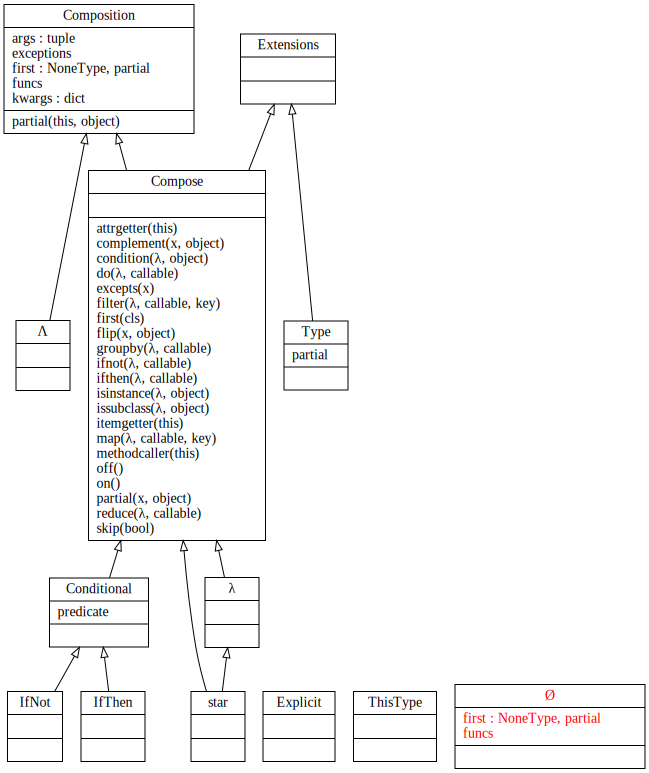

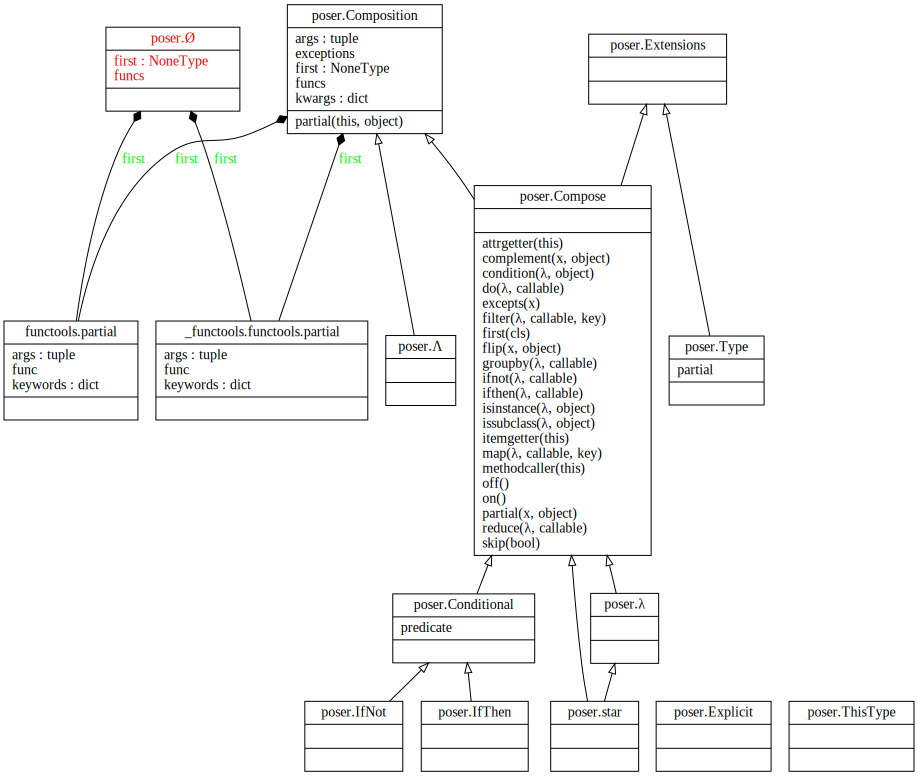

In [17]:
    if __name__ == '__main__': 
        if '__file__' in locals():
            if 'covtest' in __import__('sys').argv:
                print(__import__('doctest').testmod(optionflags=8))
        else:
            import IPython
            from IPython import get_ipython
            !jupyter nbconvert --to python --TemplateExporter.exclude_input_prompt=True poser.ipynb
            with IPython.utils.capture.capture_output():
                !black poser.py
            !isort poser.py
            !pyflakes poser.py
            !ipython -m coverage -- run poser.py covtest
            !coverage report
            !coverage html
            with IPython.utils.capture.capture_output():
                !pyreverse poser -osvg -pposer
            IPython.display.display(IPython.display.SVG('classes_poser.svg'))
            with IPython.utils.capture.capture_output():
                !pyreverse poser -osvg -pposer -my -s1
            IPython.display.display(IPython.display.SVG('classes_poser.svg'))